# CogPonder: Stroop Task with Fixed Hyper-parameters

This notebook implements the CogPonder algorithm using PyTorch Lightning to perfrom the Stroop task. It assumes fixed hyper-parameters and fits the model to a single-subject dataset. It wraps a simple linear network with a pondering layer and trains it on the *Self-Regulation Ontology* dataset.


## Data

Here, we fit the Stroop data from the *Self-Regulation Ontology*. The data is loaded from the `data/Self_Regulation_ontology/` directory. See the `data/Self_Regulation_ontology/README.md` file for more information.

### Input and Output

#### Stroop

The input is the 1) color and 2) letter of the current stimuli. The output is the human response to the current trial (red, green, or blue).


#### N-Back

Previous N+1 presented symbols are used as input, the last input is the current symbol. The output is the human response to the N+1th trial.


## Hyper-parameters

- `n_embeddings`: number of hidden units in the operator model. Defaults to $N_{\text{symbols} + 1}$
- `rec_loss_beta`: the beta parameter of the loss function. Defaults to 0.5.
- `cog_loss_beta`: the beta parameter of the loss function. Defaults to 0.5.
- `learning_rate`: the learning rate of the optimizer. Defaults to 0.0001.
- `max_response_step`: maximum response step in the dataset. Defaults to $\max(\text{response\_step}) + 10$.

## Criterion

$L = L_{\text{reconstruction}} + L_{\text{cognitive}}$


In [50]:
%reload_ext autoreload
%autoreload 3

import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from ray import tune, air
from ray.tune import JupyterNotebookReporter
from functools import partial
from pytorch_lightning.callbacks import RichProgressBar, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from src.cogponder import CogPonderModel
from src.cogponder.datasets import StroopSRODataset, NBackSRODataset, CogPonderDataModule
from src.cogponder.losses import ReconstructionLoss, CognitiveLoss
from pathlib import Path




In [51]:
# Load the dataset and configs

TASK = 'stroop'  # or nback

match TASK:
    case 'nback':
        print('Loading N-back dataset...')
        data = NBackSRODataset(n_subjects=1, n_back=2) # shape (n_subjects, (...))
        n_symbols = torch.unique(data[0][0]).shape[0]
        embeddings_dim = n_symbols
        max_response_step = 30 # OR something like "2 * max observed RT"
    case 'stroop':
        print('Loading Stroop dataset...')
        data = StroopSRODataset(n_subjects=1)
        embeddings_dim = 2
        max_response_step = 100

# parameter space
CONFIG = {
    'rec_loss_beta': 1.,
    'cog_loss_beta': 10.,
    'non_decision_time': 1,  # in milliseconds
    'loss_by_trial_type': False,
    'learning_rate': 1e-2,
    'max_response_step': max_response_step,
    'inputs_dim': data[0][0].size(1),
    'embeddings_dim': embeddings_dim,
    'outputs_dim': torch.unique(data[0][3]).size(0),  # number of unique responses
    'auto_lr_find': False,
    'task': TASK,
    'batch_size': 196,
}

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Loading Stroop dataset...


In [52]:
# pondering model

datamodule = CogPonderDataModule(data, batch_size=CONFIG['batch_size'], num_workers=1)
model = CogPonderModel(CONFIG, example_input_array=data[0][0][:1].to(device))

trainer = pl.Trainer(
    max_epochs=10000,
    # min_epochs=100,
    accelerator='auto',
    auto_lr_find=CONFIG['auto_lr_find'],
    log_every_n_steps=1,
    overfit_batches=True,
    # accumulate_grad_batches=2,
    callbacks=[
        RichProgressBar(),
        EarlyStopping(monitor='val/loss', patience=1000, mode='min', min_delta=0.001),
    ])

if CONFIG['auto_lr_find']:
    trainer.tune(model, datamodule=datamodule)

trainer.fit(model, datamodule=datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃   ┃ Name           ┃ Type               ┃ Params ┃         In sizes ┃ Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ 0 │ train_accuracy │ Accuracy           │      0 │                ? │         ? │
│ 1 │ val_accuracy   │ Accuracy           │      0 │                ? │         ? │
│ 2 │ cog_loss_fn    │ CognitiveLoss      │      0 │                ? │         ? │
│ 3 │ rec_loss_fn    │ ReconstructionLoss │      0 │                ? │         ? │
│ 4 │ halt_node      │ Sequential         │      9 │           [1, 2] │    [1, 1] │
│ 5 │ output_node    │ Sequential         │     15 │           [1, 2] │    [1, 3] │
│ 6 │ recurrent_node │ GRUCell            │     36 │ [[1, 2], [1, 2]] │    [1, 2] │
└───┴────────────────┴────────────────────┴────────┴──────────────────┴───────────┘

Trainable params: 60                                                                                               
Non-trainable params: 0                                                                                            
Total params: 60                                                                                                   
Total estimated model params size (MB): 0

Output()

/home/morteza/mambaforge/envs/ponder/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connect
or.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this
machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

/home/morteza/mambaforge/envs/ponder/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connect
or.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a 
bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this
machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(

In [53]:
# DEBUG: Plot LR tuning results
# lr_finder = trainer.tuner.lr_find(model, max_lr=2, datamodule=datamodule)
# fig = lr_finder.plot(suggest=True)
# fig.show()
# model.hparams.learning_rate = lr_finder.suggestion()
# trainer.fit(model, datamodule=datamodule)

In [59]:
# DEBUG

import torch
import torchmetrics

X_train, _, _, y_train, rt_train = datamodule.dataset[datamodule.train_dataset.indices]
X_test, _, _, y_test, rt_test = datamodule.dataset[datamodule.test_dataset.indices]


print(X_train.to(device).device)

with torch.no_grad():
    model.eval()

    y_train_steps,_,rt_train_pred = model(X_train)
    y_test_steps,_,rt_test_pred = model(X_test)
    
    y_train_steps = torch.argmax(y_train_steps, dim=-1)
    y_test_steps = torch.argmax(y_test_steps, dim=-1)

    y_train_pred = y_train_steps.gather(dim=0, index=rt_train_pred[None, :] - 1,)[0]  # (batch_size,)
    y_test_pred = y_test_steps.gather(dim=0, index=rt_test_pred[None, :] - 1,)[0]  # (batch_size,)

    if TASK == 'nback':
        accuracy_fn = torchmetrics.Accuracy().to(device)
        train_accuracy = accuracy_fn(y_train_pred, y_train.int())
        print('TRAIN ACCURACY', train_accuracy.item())

        accuracy_fn = torchmetrics.Accuracy().to(device)
        test_accuracy = accuracy_fn(y_test_pred, y_test.int())
        print('TEST ACCURACY', test_accuracy.item())

    # DEBUG report the ground truth and predicted response times
    print('RT TRUE TRAIN:', rt_train.detach().tolist(), '\nRT PRED TRAIN:',  rt_train_pred.tolist())
    print('RT TRUE TEST:', rt_test.detach().tolist(), '\nRT PRED TEST:',  rt_test_pred.tolist())

# DEBUG report medians
print('RT mean (pred/true): ', rt_train_pred.float().mean().item(), rt_train.float().mean().item())
print('RT mean (pred/true): ', rt_test_pred.float().mean().item(), rt_test.float().mean().item())


cuda:0
RT TRUE TRAIN: [54, 30, 32, 44, 35, 45, 33, 38, 33, 63, 45, 38, 38, 30, 38, 26, 25, 31, 47, 37, 44, 49, 44, 39, 50, 37, 46, 51, 37, 44, 54, 34, 42, 54, 36, 45, 44, 43, 41, 51, 30, 69, 51, 43, 39, 31, 47, 32, 32, 25, 60, 45, 46, 45, 52, 53, 59, 57, 47, 52, 42, 50, 32, 26, 23, 24, 44, 28, 49, 48, 39] 
RT PRED TRAIN: [54, 18, 92, 84, 100, 5, 49, 61, 44, 100, 45, 46, 93, 18, 16, 19, 4, 100, 100, 45, 100, 84, 46, 23, 6, 100, 72, 26, 39, 46, 45, 15, 46, 43, 32, 46, 5, 91, 46, 16, 100, 11, 45, 48, 29, 69, 46, 46, 13, 17, 47, 55, 44, 8, 47, 9, 45, 66, 10, 62, 57, 45, 46, 46, 49, 45, 28, 78, 100, 17, 20]
RT TRUE TEST: [34, 35, 57, 31, 29, 39, 66, 49, 31, 73, 67, 41, 38, 44, 33, 72, 47, 40, 56, 36, 66, 37, 46, 29] 
RT PRED TEST: [55, 47, 51, 21, 100, 46, 92, 48, 48, 48, 18, 46, 45, 74, 100, 46, 58, 49, 49, 13, 100, 78, 13, 48]
RT mean (pred/true):  47.43661880493164 41.78873062133789
RT mean (pred/true):  53.875 45.66666793823242


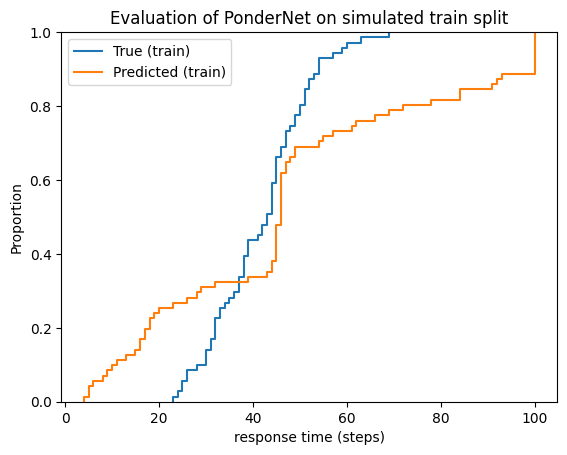

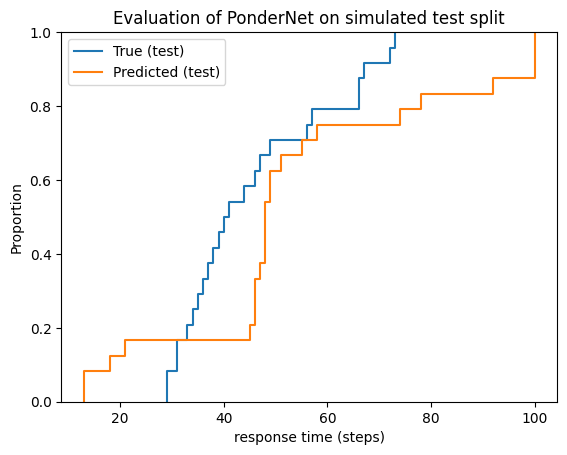

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

RT_CAP = max_response_step + 1 # data[0][4].max().item()

sns.ecdfplot(rt_train, label='True (train)')
sns.ecdfplot(rt_train_pred[rt_train_pred < RT_CAP].cpu(), label='Predicted (train)')

plt.title(f'Evaluation of PonderNet on train split (SRO {TASK})')
plt.xlabel('response time (steps)')

plt.legend()
plt.show()

sns.ecdfplot(rt_test, label='True (test)')
sns.ecdfplot(rt_test_pred[rt_test_pred < RT_CAP].cpu(), label='Predicted (test)')

plt.title(f'Evaluation of PonderNet on test split (SRO {TASK})')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()

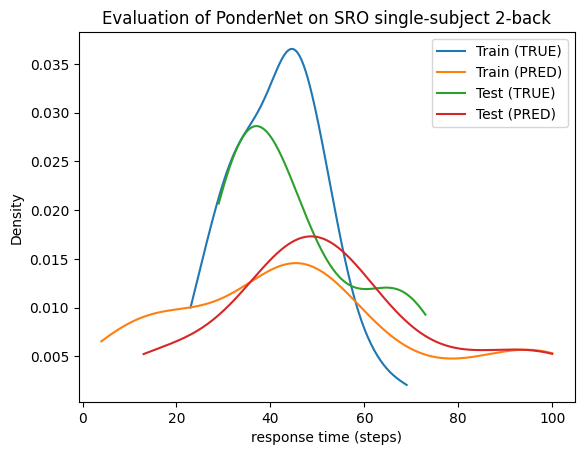

In [61]:

sns.kdeplot(rt_train, label='Train (TRUE)', cut=0)
sns.kdeplot(rt_train_pred[rt_train_pred < RT_CAP].cpu(), label='Train (PRED)', cut=0)

sns.kdeplot(rt_test, label='Test (TRUE)', cut=0)
sns.kdeplot(rt_test_pred[rt_test_pred < RT_CAP].cpu(), label='Test (PRED)', cut=0)


plt.title(f'Evaluation of PonderNet on SRO single-subject {TASK}')
plt.xlabel('response time (steps)')
plt.legend()
plt.show()